# 01_Preprocessing

### Overview
This notebook focuses on data preprocessing for Crunch 1 of the Autoimmune Disease Machine Learning Challenge. The preprocessing step is critical to prepare the raw spatial transcriptomics data and H&E images for downstream modeling tasks. It ensures data quality, consistency, and compatibility with machine learning algorithms.

---

### Objectives
1. **Data Loading**: Load and validate raw data files (e.g., Zarr, H&E images, and gene expression tables).
2. **Image Preprocessing**:
   - Normalize H&E images.
   - Extract nucleus-centered patches for modeling.
3. **Gene Expression Preprocessing**:
   - Normalize and filter gene expression data.
   - Perform dimensionality reduction and clustering.
4. **Spatial Feature Engineering**:
   - Compute spatial features such as centroids, pairwise distances, and adjacency matrices.
5. **Save Outputs**: Store preprocessed data in the `interim` directory for use in downstream tasks.

---

### Expected Outputs
- **Processed H&E Images**:
  - Nucleus-centered patches with normalized intensities.
- **Processed Gene Expression**:
  - Normalized, filtered, and clustered gene expression data.
- **Spatial Features**:
  - Centroids, distances, and adjacency matrices for nuclei.

---

### Steps
1. **Imports and Configuration**: Load necessary libraries and initialize configurations.
2. **Data Loading**: Load raw data using the `DataLoader`.
3. **Preprocessing Tasks**:
   - Image Preprocessing (`ImagePreprocessor`).
   - Gene Expression Preprocessing (`GenePreprocessor`).
   - Spatial Preprocessing (`SpatialPreprocessor`).
4. **Save Outputs**: Ensure all preprocessed data is saved to the `interim` directory.
5. **Validation**: Validate preprocessed data visually or through summary statistics.


## Step 1. Imports and Configuration
This section initializes the preprocessing environment by:
- Importing core libraries and project-specific modules.
- Loading the configuration file (`config.yaml`) for path management.
- Setting up paths for raw and interim data.

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import spatialdata_plot
import spatialdata as sd
import scanpy as sc

/home/secondbook5/micromamba/envs/autoimmune_ml/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
# Import project-specific modules
from src.config.config_loader import ConfigLoader
from src.data_loader import DataLoader
from src.preprocessors.image_preprocessor import ImagePreprocessor
from src.preprocessors.gene_preprocessor import GenePreprocessor
from src.preprocessors.spatial_preprocessor import SpatialPreprocessor

In [3]:
# Load configuration and DataLoader for Crunch1
config_path = "/home/secondbook5/projects/AutoImmuneML/config.yaml"
config = ConfigLoader(config_path=config_path)
crunch_name = "crunch1"
# initialize data loader
data_loader = DataLoader(config=config, crunch_name="crunch1")


# Set paths
raw_dir = config.get_crunch_path(crunch_name, "raw_dir")
interim_dir = config.get_crunch_path(crunch_name, "interim_dir")

# Display paths
print(f"Raw directory: {raw_dir}")
print(f"Interim directory: {interim_dir}")

Raw directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data
Interim directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/interim


## 2. Data Loading
This section loads the raw data from Zarr files using the `DataLoader`. The data includes:
1. **Images**: H&E registered images.
2. **Tables**: Gene expression data.

We also display a sample image and inspect the structure of the gene expression table to ensure correctness.


In [4]:
# Load all Zarr files in the raw directory
print(f"[INFO] Loading all Zarr files in directory: {raw_dir}")
all_zarr_data = data_loader.load_zarr([raw_dir])

# Display loaded datasets
print(f"[INFO] All loaded datasets: {list(all_zarr_data.keys())}")


[INFO] Loading all Zarr files in directory: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data


Loading Zarr files: 100%|██████████| 8/8 [02:04<00:00, 15.51s/it]

[INFO] All loaded datasets: ['DC1.zarr', 'UC1_NI.zarr', 'DC5.zarr', 'UC1_I.zarr', 'UC6_NI.zarr', 'UC6_I.zarr', 'UC7_I.zarr', 'UC9_I.zarr']


In [4]:
# Specify the Zarr file to process
single_zarr_key = "UC1_NI.zarr"  # Replace with your target file name
single_zarr_path = os.path.join(config.get_crunch_path("crunch1", "raw_dir"), single_zarr_key)

# Load the Zarr file using DataLoader
print(f"[INFO] Loading Zarr file: {single_zarr_path}")
sdata = data_loader.load_zarr(single_zarr_path)

# Print the structure of the loaded data
print(sdata)


[INFO] Loading Zarr file: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data/UC1_NI.zarr


Loading Zarr files: 100%|██████████| 1/1 [00:24<00:00, 24.81s/it]


{'UC1_NI.zarr': SpatialData object, with associated Zarr store: /mnt/d/AutoImmuneML/broad-1-autoimmune-crunch1/data/UC1_NI.zarr
├── Images
│     ├── 'DAPI': DataArray[cyx] (1, 51060, 53998)
│     ├── 'DAPI_nuc': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 21000, 22000)
│     ├── 'HE_nuc_registered': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_original': DataArray[cyx] (3, 21000, 22000)
│     ├── 'HE_registered': DataArray[cyx] (3, 51060, 53998)
│     ├── 'group': DataArray[cyx] (1, 51060, 53998)
│     └── 'group_HEspace': DataArray[cyx] (1, 21000, 22000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (2D points)
└── Tables
      ├── 'anucleus': AnnData (80037, 460)
      └── 'cell_id-group': AnnData (93686, 0)
with coordinate systems:
    ▸ 'global', with elements:
        DAPI (Images), DAPI_nuc (Images), HE_nuc_original (Images), HE_nuc_registered (Images), HE_original (Images), HE_registered (Images), group (Images), 

AttributeError: 'dict' object has no attribute 'pl'

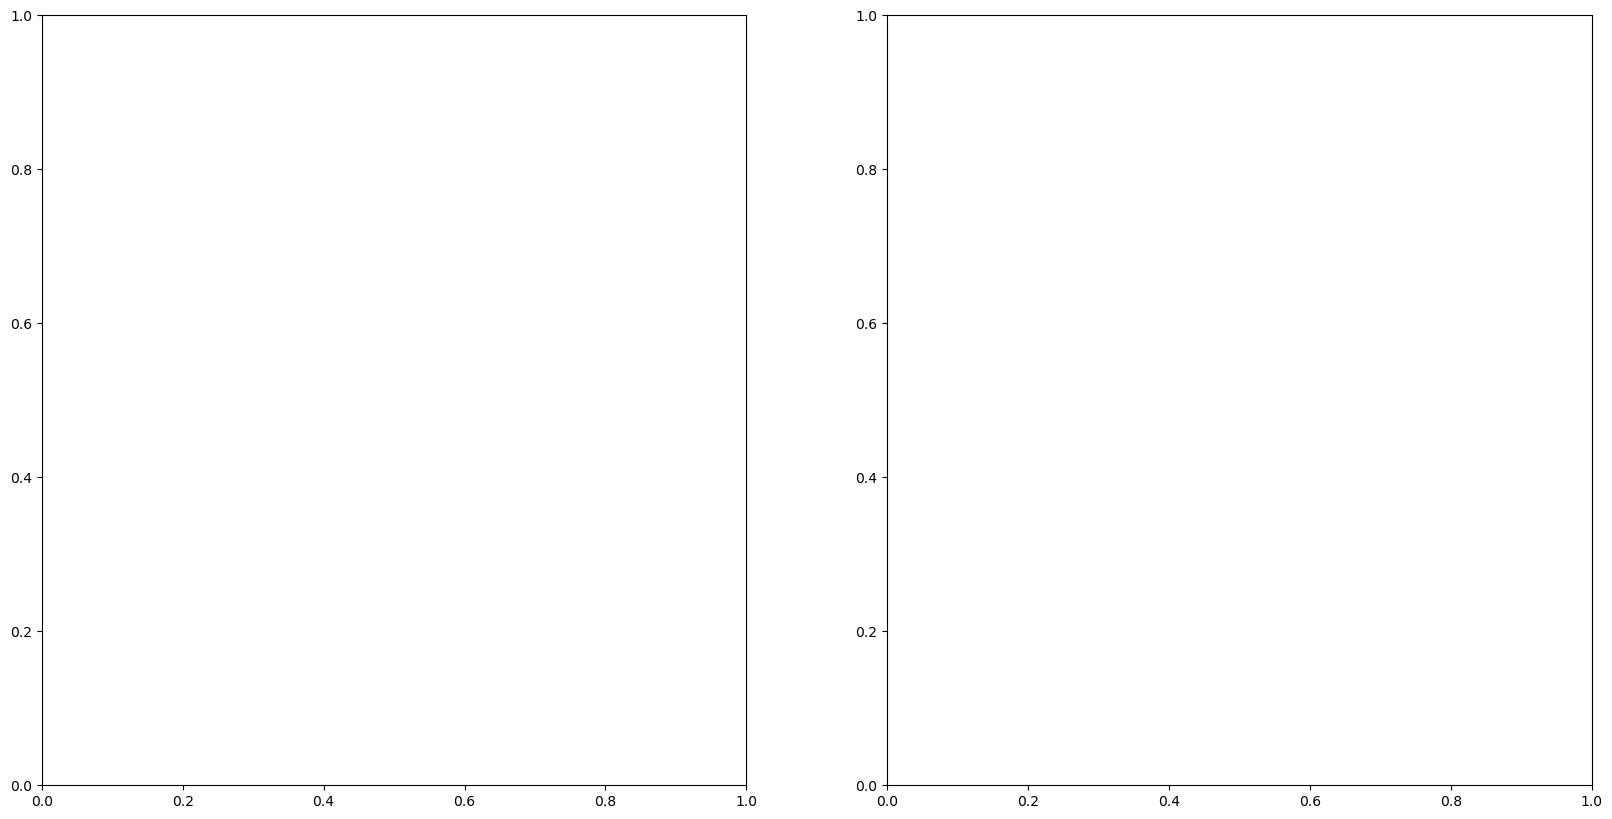

In [7]:
##  H&E pathology image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes to easily index them

sdata.pl.render_images("HE_nuc_original").pl.show(ax=axes[0], title="H&E registered image", coordinate_systems="global")
sdata.pl.render_images("HE_original").pl.show(ax=axes[1], title="H&E original image", coordinate_systems="global")

AttributeError: 'SpatialData' object has no attribute 'pl'

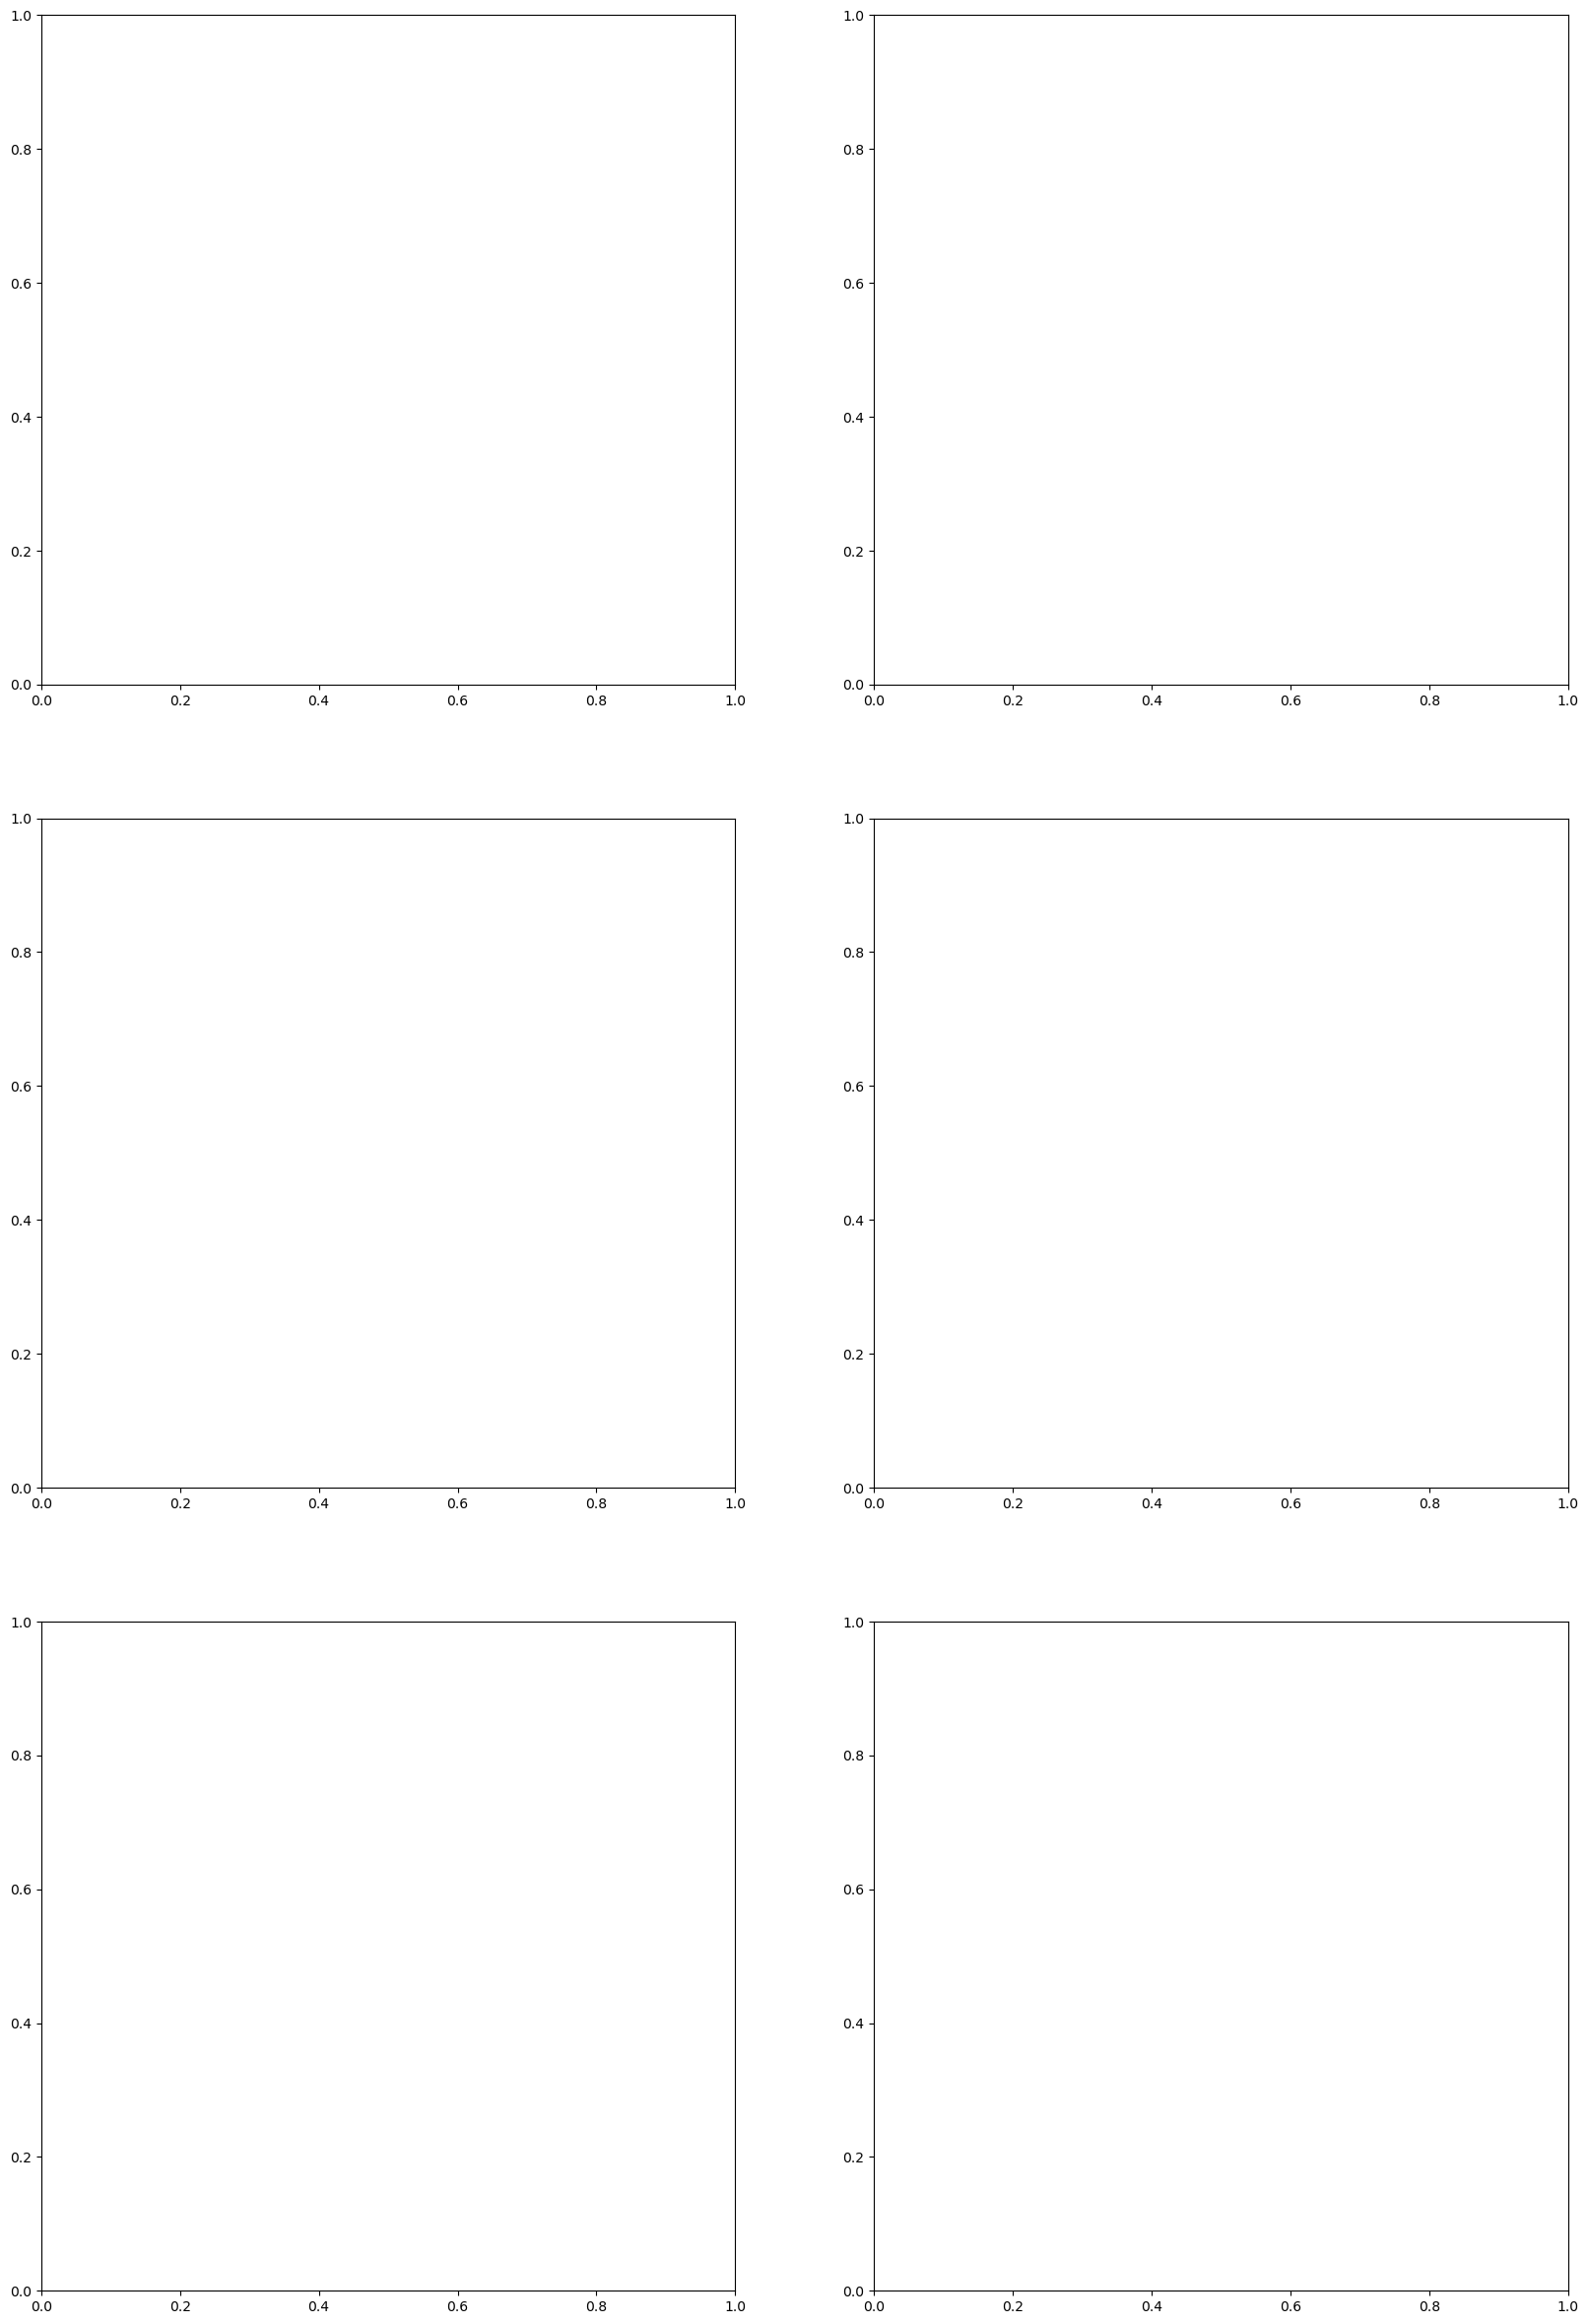

In [6]:
# Create a 3x2 grid for visualizing images and their corresponding nucleus masks
fig, axes = plt.subplots(3, 2, figsize=(20, 30))  # Define the layout: 3 rows, 2 columns
axes = axes.flatten()  # Flatten the grid for easy indexing (convert to a 1D array of axes)

# Define the image-mask pairs to render side by side
image_mask_pairs = [
    ("HE_registered", "HE_nuc_registered"),  # Row 1: H&E Registered image and its nucleus mask
    ("HE_original", "HE_nuc_original"),     # Row 2: H&E Original image and its nucleus mask
    ("DAPI", "DAPI_nuc")                    # Row 3: DAPI image and its nucleus mask
]

# Loop through the image-mask pairs and render them
for idx, (image_key, mask_key) in enumerate(image_mask_pairs):
    # --- Left Column: Render the main image ---
    if image_key in sdata[single_zarr_key].images.keys():  # Check if the image key exists in the dataset
        # Render the image and display it in the appropriate subplot
        sdata[single_zarr_key].pl.render_images(image_key).pl.show(
            ax=axes[idx * 2],  # Left column for the current row
            title=f"{image_key.replace('_', ' ').title()}",  # Format the title (replace underscores with spaces)
            coordinate_systems="global"  # Use the global coordinate system for alignment
        )
    else:
        # Handle missing image keys by displaying a placeholder
        axes[idx * 2].set_title(f"{image_key}: Not Found")  # Display a "Not Found" title
        axes[idx * 2].axis("off")  # Turn off the axis to clean up the appearance

    # --- Right Column: Render the corresponding nucleus mask ---
    if mask_key in sdata[single_zarr_key].images.keys():  # Check if the mask key exists in the dataset
        # Render the mask and display it in the corresponding subplot
        sdata[single_zarr_key].pl.render_images(mask_key).pl.show(
            ax=axes[idx * 2 + 1],  # Right column for the current row
            title=f"{mask_key.replace('_', ' ').title()}",  # Format the title (replace underscores with spaces)
            coordinate_systems="global"  # Use the global coordinate system for alignment
        )
    else:
        # Handle missing mask keys by displaying a placeholder
        axes[idx * 2 + 1].set_title(f"{mask_key}: Not Found")  # Display a "Not Found" title
        axes[idx * 2 + 1].axis("off")  # Turn off the axis to clean up the appearance

# Adjust the layout to ensure proper spacing and readability of subplots
plt.tight_layout()

# Display the figure with the rendered images and masks
plt.show()


In [ ]:
# Inspect loaded Zarr datasets
print("[INFO] Inspecting loaded Zarr datasets...")

for key, dataset in zarr_data.items():
    print(f"[INFO] Dataset: {key}")

    # Check available images
    if hasattr(dataset, "images") and dataset.images.keys():
        print(f"  - Images: {list(dataset.images.keys())}")

        # Display the first sample image for inspection
        sample_image_key = list(dataset.images.keys())[0]
        sample_image = dataset.images[sample_image_key].values
        plt.figure(figsize=(6, 6))
        plt.title(f"{key} - Image: {sample_image_key}")
        plt.imshow(sample_image, cmap="gray")
        plt.axis("off")
        plt.show()
    else:
        print("  - No images found.")

    # Check available tables
    if hasattr(dataset, "tables") and dataset.tables.keys():
        print(f"  - Tables: {list(dataset.tables.keys())}")

        # Display a preview of the first table
        for table_key in dataset.tables.keys():
            table = dataset.tables[table_key]
            df = table.to_pandas()
            print(f"\nSample rows from table '{table_key}':")
            print(df.head(5))
    else:
        print("  - No tables found.")


[INFO] Inspecting loaded Zarr datasets...
[INFO] Dataset: UC1_NI.zarr
  - Images: ['DAPI', 'DAPI_nuc', 'HE_nuc_original', 'HE_nuc_registered', 'HE_original', 'HE_registered', 'group', 'group_HEspace']


In [8]:
# Display Sample Image and Metadata
sample_image = zarr_data["UC1_NI"]["images"]["HE_registered"]
plt.imshow(sample_image)
plt.title("Sample H&E Registered Image")
plt.show()

# Display Sample Gene Expression Data
gene_expression = pd.DataFrame(zarr_data["UC1_NI"]["tables"]["anucleus"].to_numpy())
print(gene_expression.head())

KeyError: 'UC1_NI'

## 3. Preprocessing Tasks

### 3.1 H&E Image Preprocessing
- Normalize stains using Reinhard normalization.
- Extract nucleus-centered patches.
- Apply augmentations.


In [ ]:
# Initialize Image Preprocessor
image_preprocessor = ImagePreprocessor()

# Normalize and Extract Patches
for zarr_key, dataset in zarr_data.items():
    he_images = dataset["images"]["HE_registered"]
    he_nuc_masks = dataset["images"]["HE_nuc_registered"]

    # Example: Normalize
    normalized_images = image_preprocessor.normalize_stains(he_images)

    # Example: Patch Extraction
    patches = image_preprocessor.extract_patches(he_images, he_nuc_masks, patch_size=32)

    # Save to Interim Directory
    save_path = os.path.join(interim_dir, f"{zarr_key}_processed_images.npy")
    np.save(save_path, patches)


### 3.2 Gene Expression Preprocessing
- Normalize and filter gene expression data.
- Log-transform if needed.


In [ ]:
# Initialize Gene Preprocessor
gene_preprocessor = GenePreprocessor()

# Normalize Gene Expression
for zarr_key, dataset in zarr_data.items():
    anucleus_table = dataset["tables"]["anucleus"]
    normalized_genes = gene_preprocessor.normalize(anucleus_table)

    # Save to Interim Directory
    save_path = os.path.join(interim_dir, f"{zarr_key}_processed_genes.npy")
    np.save(save_path, normalized_genes)


### 3.3 Spatial Feature Engineering
- Compute distances between nuclei.
- Create adjacency matrices for spatial modeling.


In [ ]:
# Initialize Spatial Preprocessor
spatial_preprocessor = SpatialPreprocessor()

# Compute Features
for zarr_key, dataset in zarr_data.items():
    spatial_features = spatial_preprocessor.generate_features(dataset)

    # Save to Interim Directory
    save_path = os.path.join(interim_dir, f"{zarr_key}_spatial_features.npy")
    np.save(save_path, spatial_features)


## 4. Intermediate Validation
- Visualize preprocessed images, gene distributions, and spatial features.


In [ ]:
# Visualize Preprocessed Images
plt.imshow(patches[0])
plt.title("Example Preprocessed Patch")
plt.show()

# Plot Gene Expression Distribution
plt.hist(normalized_genes.flatten(), bins=50)
plt.title("Normalized Gene Expression Distribution")
plt.show()


## 5. Save Preprocessed Data
- Save all outputs to the `interim` directory.

In [ ]:
# Ensure Preprocessed Data is Stored Correctly
assert os.path.exists(interim_dir), "Interim directory does not exist!"

## 6. Notes and Next Steps
- Preprocessing is complete. The next step is Enhanced EDA.
- Key Observations:
  - ...
  - ...
